In [1]:
# --- CELL 1: Setup & Imports ---
import pandas as pd
import numpy as np
import torch
import feedparser
import requests
import os
import joblib
from bs4 import BeautifulSoup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from urllib.parse import quote
from datetime import datetime

# 1. Setup Device (GPU is highly recommended for FinBERT)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

# 2. Load FinBERT (The Universal Brain)
print("Loading FinBERT... (This handles the 'Universal Language' of Finance)")
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(device)
print("✅ FinBERT Loaded.")

Using Device: cuda
Loading FinBERT... (This handles the 'Universal Language' of Finance)
✅ FinBERT Loaded.


In [2]:
# --- CELL 2: Configuration & Filters ---

# PATH TO YOUR DATASET (Update this if needed)
CSV_PATH = r"D:\Study\Projects\GenWealth\notebooks\News Data\raw_partner_headlines.csv"
OUTPUT_DIR = "../model_artifacts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# JUNK FILTER: We discard headlines containing these words to save time/compute
# These are usually generic market wrap-ups that don't move specific stocks
JUNK_KEYWORDS = [
    "market update", "what to watch", "earnings preview", "stocks moving", 
    "why is", "markets rally", "top stocks", "etf", "mutual fund",
    "dividend", "yield", "buy or sell", "technical analysis"
]

def is_relevant(headline):
    """Returns False if the headline is generic noise."""
    hl_lower = str(headline).lower()
    for junk in JUNK_KEYWORDS:
        if junk in hl_lower:
            return False
    return True

print("✅ Filters Configured.")

✅ Filters Configured.


In [3]:
# --- CELL 3: The Sentiment Factory (Batch Processor) ---

def get_sentiment_batch(headlines):
    """
    Takes a LIST of headlines and returns (Score, Confidence) for each.
    Uses GPU batch processing for 10x speed.
    """
    inputs = tokenizer(headlines, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # FinBERT Output: [Neutral_Logit, Positive_Logit, Negative_Logit] (Check model docs for specific order)
    # yiyanghkust/finbert-tone order: [Neutral, Positive, Negative]
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    
    # We want a single "Sentiment Score" from -1 (Bad) to +1 (Good)
    # Logic: (Positive * 1) + (Negative * -1)
    # Neutral is ignored in the score but affects confidence
    
    probs_np = probs.cpu().numpy()
    
    # Column 0: Neutral, Column 1: Positive, Column 2: Negative
    # Score = Prob(Pos) - Prob(Neg)
    scores = probs_np[:, 1] - probs_np[:, 2]
    
    # Confidence = Max probability of the prediction
    confidences = np.max(probs_np, axis=1)
    
    return scores, confidences

print("✅ Batch Processing Engine Ready.")

✅ Batch Processing Engine Ready.


In [4]:
# --- CELL 4: Run the Backtest Processor (The Heavy Lifter) ---

# 1. Load Data
print(f"Reading CSV from: {CSV_PATH}...")
# Reading only columns we need to save memory
df = pd.read_csv(CSV_PATH, usecols=['headline', 'date', 'stock'])

# --- TEST MODE: LIMIT TO 10,000 ROWS FOR FIRST RUN ---
# Comment this line out to run the full 390MB file (will take hours)
#df = df.head(10000) 
print(f"Loaded {len(df)} rows. Filtering Junk...")

# 2. Filter Junk
original_len = len(df)
df = df[df['headline'].apply(is_relevant)].copy()
print(f"Filtered out {original_len - len(df)} junk articles. Remaining: {len(df)}")

# 3. Process in Batches
BATCH_SIZE = 32 # Adjust based on your VRAM (32 is safe for 4GB)
all_scores = []
all_confs = []

print("Starting FinBERT Analysis... (Watch the GPU)")
headlines = df['headline'].tolist()

for i in range(0, len(headlines), BATCH_SIZE):
    batch = headlines[i : i+BATCH_SIZE]
    scores, confs = get_sentiment_batch(batch)
    all_scores.extend(scores)
    all_confs.extend(confs)
    
    if i % 1000 == 0:
        print(f"Processed {i}/{len(headlines)}...")

df['sentiment_score'] = all_scores
df['confidence'] = all_confs

# 4. Aggregation Logic (The "Weighted Average")
# We group by Date and Stock to get one score per day
print("Aggregating Daily Scores...")

def weighted_avg(group):
    d = {}
    # Formula: Sum(Score * Conf) / Sum(Conf)
    d['daily_score'] = (group['sentiment_score'] * group['confidence']).sum() / group['confidence'].sum()
    d['news_count'] = group['sentiment_score'].count()
    return pd.Series(d)

df_daily = df.groupby(['date', 'stock']).apply(weighted_avg).reset_index()

# 5. Save the Memory Bank
pkl_path = f"{OUTPUT_DIR}/universal_sentiment_history.pkl"
df_daily.to_pickle(pkl_path)
print(f"✅ SUCCESS! Memory Bank saved to: {pkl_path}")
print(df_daily.head())

Reading CSV from: D:\Study\Projects\GenWealth\notebooks\News Data\raw_partner_headlines.csv...
Loaded 1845559 rows. Filtering Junk...
Filtered out 185945 junk articles. Remaining: 1659614
Starting FinBERT Analysis... (Watch the GPU)
Processed 0/1659614...
Processed 4000/1659614...
Processed 8000/1659614...
Processed 12000/1659614...
Processed 16000/1659614...
Processed 20000/1659614...
Processed 24000/1659614...
Processed 28000/1659614...
Processed 32000/1659614...
Processed 36000/1659614...
Processed 40000/1659614...
Processed 44000/1659614...
Processed 48000/1659614...
Processed 52000/1659614...
Processed 56000/1659614...
Processed 60000/1659614...
Processed 64000/1659614...
Processed 68000/1659614...
Processed 72000/1659614...
Processed 76000/1659614...
Processed 80000/1659614...
Processed 84000/1659614...
Processed 88000/1659614...
Processed 92000/1659614...
Processed 96000/1659614...
Processed 100000/1659614...
Processed 104000/1659614...
Processed 108000/1659614...
Processed 1120

C:\Users\taher\AppData\Local\Temp\ipykernel_7560\2832058722.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_daily = df.groupby(['date', 'stock']).apply(weighted_avg).reset_index()


✅ SUCCESS! Memory Bank saved to: ../model_artifacts/universal_sentiment_history.pkl
                  date stock  daily_score  news_count
0  1969-12-31 00:00:00   MRH     0.000079         1.0
1  2010-02-03 00:00:00  ADPT    -0.002522         1.0
2  2010-02-03 00:00:00   ASH    -0.000149         1.0
3  2010-02-03 00:00:00   DTV    -0.000031         1.0
4  2010-02-03 00:00:00   FLR     1.000000         1.0


Total Daily Rows: 1153845
Non-Zero Scores: 1153836

Date Range: 1969-12-31 00:00:00 to 2020-06-04 00:00:00


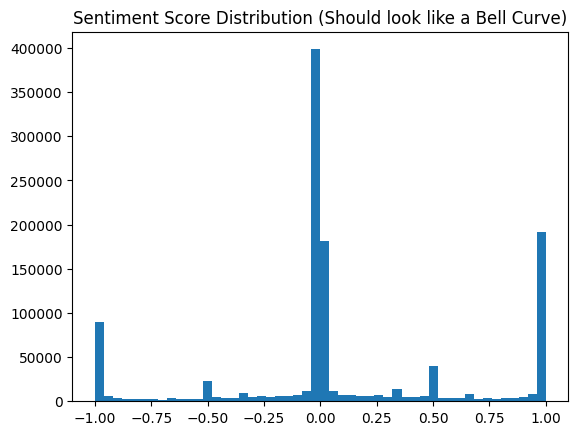


Sample Data for AAPL:
                        date stock  daily_score  news_count
1151594  2020-05-27 00:00:00  AAPL     0.000088         1.0
1151904  2020-05-28 00:00:00  AAPL     0.150212         8.0
1152426  2020-05-29 00:00:00  AAPL     0.200182         5.0
1152777  2020-05-30 00:00:00  AAPL     0.167139         6.0
1152855  2020-05-31 00:00:00  AAPL    -0.162263         6.0


In [5]:
# Cell 4.5
# --- QUALITY CONTROL CHECK ---

import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the file you just made
check_df = pd.read_pickle(f"{OUTPUT_DIR}/universal_sentiment_history.pkl")

# 2. Check for "Flatline" (All zeros means something broke)
print(f"Total Daily Rows: {len(check_df)}")
print(f"Non-Zero Scores: {len(check_df[check_df['daily_score'] != 0])}")

# 3. Sanity Check Dates
print(f"\nDate Range: {check_df['date'].min()} to {check_df['date'].max()}")

# 4. Check Distribution (We want a mix of positive/negative)
plt.hist(check_df['daily_score'], bins=50)
plt.title("Sentiment Score Distribution (Should look like a Bell Curve)")
plt.show()

# 5. Spot Check a specific stock (e.g., AAPL)
print("\nSample Data for AAPL:")
print(check_df[check_df['stock'] == 'AAPL'].head())

In [9]:
# --- CELL 5: The Live Scraper (For Today's News) ---

def get_live_sentiment(ticker):
    """
    1. Searches Google News for the ticker (works for Indian/US stocks).
    2. Analyzes headlines with FinBERT.
    3. Returns the Weighted Sentiment Score.
    """
    # 1. Fetch Headlines
    # We add "stock news" to ensure we get financial context
    query = f"{ticker} stock news"
    rss_url = f"https://news.google.com/rss/search?q={quote(query)}&hl=en-IN&gl=IN&ceid=IN:en"
    
    print(f"🔍 Searching: {query}...")
    feed = feedparser.parse(rss_url)
    
    if not feed.entries:
        print("No news found.")
        return 0.0
    
    headlines = [entry.title for entry in feed.entries[:10]] # Top 10 news
    print(f"Found {len(headlines)} headlines.")
    
    # 2. Analyze
    scores, confs = get_sentiment_batch(headlines)
    
    # 3. Aggregate
    if np.sum(confs) == 0: return 0.0
    
    weighted_score = np.sum(scores * confs) / np.sum(confs)
    
    print(f"📝 Headlines: {headlines[:2]}...") # Show first 2
    print(f"📊 Daily Score: {weighted_score:.4f}")
    
    return weighted_score

# Test it on an Indian Stock
print("-" * 30)
score = get_live_sentiment("NVDA")
print("-" * 30)

------------------------------
🔍 Searching: NVDA stock news...
Found 10 headlines.
📝 Headlines: ["Here are Friday's biggest analyst calls: Nvidia, Tesla, Netflix, Disney, Amazon, Honeywell, Nio, Rocket Lab & more - CNBC", 'Where Will Nvidia Stock Be in 10 Years? - The Motley Fool']...
📊 Daily Score: 0.5320
------------------------------
